## Imports and Hyper-parameter/variable declaration

In [1]:
%matplotlib inline
from utils import retrieve_texts, DataObject, data_shapes, token_integer_mapping, prepare_model_data, shape_info
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Activation, dot, Concatenate, concatenate, Lambda
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from keras.backend import argmax
from keras.callbacks import ModelCheckpoint
import datetime


batch_size = 32                # Batch size for training.
epochs = 23                    # Number of epochs to train for.
latent_dim = 3072              # Latent dimensionality of the encoding space.
do_prob = 0.2                # Dropout probability
num_samples = 5001             # Number of samples to train on.
data_dir = 'data/train/'       # Path to the data txt files on disk.
model_cp_dir = 'checkpoints/'  # Path to model checkpoints
# Maximum length for inputs and outputs (in terms of characters, not tokens)
max_input_length = 1000000     # Number of largest acceptibale input length
max_target_length = 1800       # Number of largest acceptibale target length

Using TensorFlow backend.


## Data processing

In [2]:
# Get data
input_texts, target_texts, input_lists, target_lists, input_tokens, target_tokens = retrieve_texts(data_dir, num_samples, max_input_length, max_target_length)
do = DataObject(input_texts, target_texts, input_lists, target_lists, input_tokens, target_tokens)
# Data shapes
num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length, n_input_samples = data_shapes(do)
# Converting tokens to integers (Neural Networks accept only integers as inputs), and
# reverse-lookup token index to decode sequences back to something readable.
input_token_index, target_token_index, reverse_input_token_index, reverse_target_token_index = token_integer_mapping(do.input_tokens, do.target_tokens)
# Preprare data for model training
encoder_input_data, decoder_input_data, decoder_target_data = prepare_model_data(do.input_lists, do.target_lists, input_token_index, target_token_index, n_input_samples, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)

In [3]:
# Print info
print("Training info:-")
shape_info(n_input_samples, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)
print("Batch size:", batch_size)
print("Embedding dimensionality:", latent_dim)
print("Number of training iterations:", epochs)

Training info:-
Number of samples: 5000
Number of unique input tokens: 4339
Number of unique output tokens: 4159
Max sequence length for inputs: 527
Max sequence length for outputs: 231
Batch size: 32
Embedding dimensionality: 3072
Number of training iterations: 23


## Building the model

In [4]:
def build_discriminator(latent_dim, v_size_code, v_size_pseudo, input_shape, target_shape):
    code_inputs = Input(shape=(input_shape,))
    pseudo_inputs = Input(shape=(target_shape,))
    code_x = Embedding(v_size_code, latent_dim, mask_zero=True)(code_inputs)
    pseudo_x = Embedding(v_size_pseudo, latent_dim, mask_zero=True)(pseudo_inputs)
    concatted = Concatenate(axis=1)([code_x, pseudo_x])
    # x = LSTM(latent_dim, dropout=drop_prob, recurrent_dropout=drop_prob)(concatted)
    x = LSTM(latent_dim)(concatted)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([code_inputs, pseudo_inputs], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(latent_dim, num_encoder_tokens, num_decoder_tokens, drop_prob, input_shape, target_shape):
    # Encoder
    encoder_inputs = Input(shape=(input_shape,))
    en_x = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(en_x)
    # Decoder
    decoder_inputs = Input(shape=(target_shape,))
    de_x = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
    decoder_outputs = LSTM(latent_dim, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(de_x, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(latent_dim, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(num_decoder_tokens, activation="softmax")(attention_context_output)
    # Build and compile model
    gen = Model([encoder_inputs, decoder_inputs], model_output)
    # gen.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    return gen


def build_gan(g_model, d_model, input_shape, target_shape):
    d_model.trainable = False
    encoder_inputs = Input(shape=(input_shape,))
    decoder_inputs = Input(shape=(target_shape,))
    gen_out = g_model([encoder_inputs, decoder_inputs])
    dis_out = d_model([encoder_inputs, Lambda(lambda x: argmax(x, axis=2))(gen_out)])
    gan = Model([encoder_inputs, decoder_inputs], [dis_out, gen_out])
    # compile model
    # opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1,100])
    
    return gan

W0906 15:19:13.141629 140569207600896 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 15:19:13.155325 140569207600896 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 15:19:13.158977 140569207600896 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 15:19:25.401426 140569207600896 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 527)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 231)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 231, 4159)    208783423   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 231)          0           model_2[1][0]                    
__________

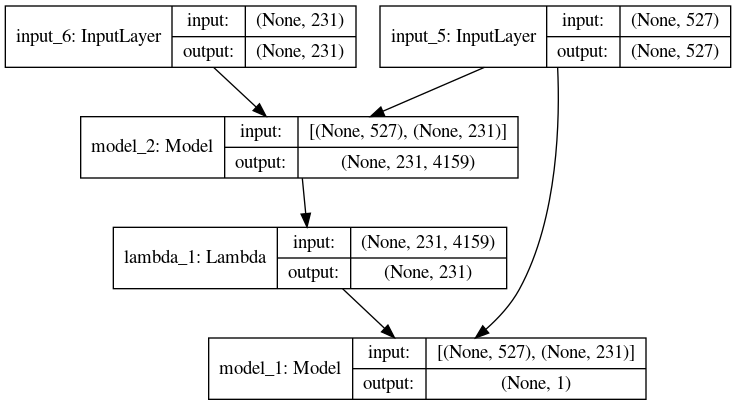

In [5]:
discriminator = build_discriminator(latent_dim, num_encoder_tokens, num_decoder_tokens, encoder_input_data.shape[1], decoder_input_data.shape[1])
generator = build_generator(latent_dim, num_encoder_tokens, num_decoder_tokens, do_prob, encoder_input_data.shape[1], decoder_input_data.shape[1])
gan_model = build_gan(generator, discriminator, encoder_input_data.shape[1], decoder_input_data.shape[1])

plot_model(discriminator, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# discriminator.summary()
# generator.summary()
gan_model.summary()

# Image('discriminator_model_plot.png')
# Image('generator_model_plot.png')
Image('gan_model_plot.png')

## Training

In [7]:
model_name = "c2p_att_plain_lat"+str(latent_dim)+"_b"+str(batch_size)+"_iter"
checkpointer = ModelCheckpoint(filepath=model_cp_dir+model_name+'{epoch:02d}.hdf5', verbose=1)
start_time = datetime.datetime.now().replace(microsecond=0)
print("Training started at:", start_time)
print("================")
generator.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])
print("================")
end_time = datetime.datetime.now().replace(microsecond=0)
print("Training completed at:", end_time)
print("Training took (h:m:s)", end_time-start_time)

Training started at: 2020-08-19 19:48:43


W0819 19:48:44.968508 140699036632832 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/23
5000/5000 [==============================] - 792s 158ms/step - loss: 6.4716

Epoch 00001: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter01.hdf5


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 3072) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 3072) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/23
5000/5000 [==============================] - 769s 154ms/step - loss: 2.6421

Epoch 00002: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter02.hdf5
Epoch 3/23
5000/5000 [==============================] - 770s 154ms/step - loss: 2.0028

Epoch 00003: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter03.hdf5
Epoch 4/23
5000/5000 [==============================] - 770s 154ms/step - loss: 1.5582

Epoch 00004: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter04.hdf5
Epoch 5/23
5000/5000 [==============================] - 770s 154ms/step - loss: 1.1754

Epoch 00005: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter05.hdf5
Epoch 6/23
5000/5000 [==============================] - 770s 154ms/step - loss: 0.8744

Epoch 00006: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter06.hdf5
Epoch 7/23
5000/5000 [==============================] - 770s 154ms/step - loss: 0.6578

Epoch 00007: saving model to checkpoints/c2p_att_plain_lat3072_b32_iter07.hdf

In [ ]:
# def build_discriminator(latent_dim, v_size_code, v_size_pseudo, input_shape, target_shape):
#     code_inputs = Input(shape=(input_shape,))
#     pseudo_inputs = Input(shape=(target_shape,))
#     code_x = Embedding(v_size_code, latent_dim, mask_zero=True)(code_inputs)
#     pseudo_x = Embedding(v_size_pseudo, latent_dim, mask_zero=True)(pseudo_inputs)
#     concatted = Concatenate(axis=1)([code_x, pseudo_x])
#     # x = LSTM(latent_dim, dropout=drop_prob, recurrent_dropout=drop_prob)(concatted)
#     x = LSTM(latent_dim)(concatted)
#     out = Dense(1, activation='sigmoid')(x)
#     disc = Model([code_inputs, pseudo_inputs], out)
#     disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
#     return disc


# def build_generator(latent_dim, num_encoder_tokens, num_decoder_tokens, drop_prob, input_shape, target_shape):
#     # Encoder
#     encoder_inputs = Input(shape=(input_shape,))
#     en_x = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
#     encoder_outputs, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(en_x)
#     # Decoder
#     decoder_inputs = Input(shape=(target_shape,))
#     de_x = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
#     decoder_outputs = LSTM(latent_dim, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(de_x, initial_state=[state_h, state_c])
#     # Attention
#     attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
#     attention = Activation('softmax', name='attention')(attention)
#     context = dot([attention, encoder_outputs], axes=[2, 1])
#     decoder_combined_context = concatenate([context, decoder_outputs])
#     attention_context_output = Dense(latent_dim, activation="tanh")(decoder_combined_context)
#     # Model output
#     model_output = Dense(num_decoder_tokens, activation="softmax")(attention_context_output)
#     # Build and compile model
#     gen = Model([encoder_inputs, decoder_inputs], model_output)
#     # gen.compile(optimizer='rmsprop', loss='categorical_crossentropy')

#     return gen


# def build_gan(g_model, d_model, input_shape, target_shape):
#     d_model.trainable = False
#     encoder_inputs = Input(shape=(input_shape,))
#     decoder_inputs = Input(shape=(target_shape,))
#     gen_out = g_model([encoder_inputs, decoder_inputs])
#     dis_out = d_model([encoder_inputs, argmax(gen_out, axis=2)])
#     gan = Model([encoder_inputs, decoder_inputs], [dis_out, gen_out])
#     # compile model
#     # opt = Adam(lr=0.0002, beta_1=0.5)
#     gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1,100])
    
#     return gan